In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [2]:
# Define the ticker symbol
tickerSymbol = 'SMH'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2022-1-1', end=date.today())

In [3]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low median {CL.median():.2%}')

SMH Close to next Low median -2.69%


In [4]:
max_weeks = 50

gap = (5/205)*100
option_prices = {
    1: [210/2.21, 220/2.93, 220/2.36], # very negative
    2: [210/3.72, 220/4.25, 220/3.92],
    3: [210/4.7, 220/5.43, 220/6.05],
    4: [210/5.6, 220/7.45, 220/6.72],
    5: [210/7.5, 220/7.9, 220/7.55],
    6: [210/7.85, 220/8.9, 220/8.55],
    7: [220/9.23],
    8: [220/10.27],
    9: [210/9.82],
    11: [220/11.85],
    12: [220/12.82],
    13: [210/12.05],
    15: [220/14.27],
    16: [220/15.12],
    17: [210/14.35],
    20: [220/17.02],
    21: [220/17.4],
    22: [210/16.75],
    28: [220/21.72],
    29: [220/21.52],
    30: [210/20.37],
    33: [220/23.87],
    34: [220/24.25],
    35: [210/22.45],
    37: [220/24.32],
    38: [220/25.05],
    39: [210/23.17]
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
option_leverage |= {
 1: 69.08212560386474,
 2: 44.9288840262582,
 3: 37.0216306156406,
 4: 30.34021816881259,
 5: 28.398378582202113,
 6: 26.281148429035753,
 7: 22.37654320987654,
 8: 21.67766258246937,
 9: 21.041970271058,
 10: 19.48051948051948,
 11: 18.42837273991655,
 12: 17.046004842615012,
 13: 16.018897996357012,
 14: 15.845070422535212,
 15: 14.603616133518775,
 16: 14.427480916030534,
 17: 14.47280134196022,
 18: 13.575425596824996,
 19: 13.333333333333334,
 20: 12.151898734177216,
 21: 12.605605100821354,
 22: 12.5,
 23: 11.560283687943263,
 24: 11.12759643916914,
 25: 11.412571627018579,
 26: 10.978520286396181}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 1w 95.0 75.1 93.2
	 2w 56.5 51.8 56.1
	 3w 44.7 40.5 36.4
	 4w 37.5 29.5 32.7
	 5w 28.0 27.8 29.1
	 6w 26.8 24.7 25.7
	 7w 23.8
	 8w 21.4
	 9w 21.4
	11w 18.6
	12w 17.2
	13w 17.4
	15w 15.4
	16w 14.6
	17w 14.6
	20w 12.9
	21w 12.6
	22w 12.5
	28w 10.1
	29w 10.2
	30w 10.3
	33w  9.2
	34w  9.1
	35w  9.4
	37w  9.0
	38w  8.8
	39w  9.1
mean option leverage, break even:
	 1w 69.1  3.9%
	 2w 44.9  4.7%
	 3w 37.0  5.1%
	 4w 30.3  5.7%
	 5w 28.4  6.0%
	 6w 26.3  6.2%
	 7w 22.4  6.9%
	 8w 21.7  7.1%
	 9w 21.0  7.2%
	10w 19.5  7.6%
	11w 18.4  7.9%
	12w 17.0  8.3%
	13w 16.0  8.7%
	14w 15.8  8.8%
	15w 14.6  9.3%
	16w 14.4  9.4%
	17w 14.5  9.3%
	18w 13.6  9.8%
	19w 13.3  9.9%
	20w 12.2 10.7%
	21w 12.6 10.4%
	22w 12.5 10.4%
	23w 11.6 11.1%
	24w 11.1 11.4%
	25w 11.4 11.2%
	26w 11.0 11.5%
	28w 10.1 12.3%
	29w 10.2 12.2%
	30w 10.3 12.1%
	33w  9.2 13.3%
	34w  9.1 13.5%
	35w  9.4 13.1%
	37w  9.0 13.5%
	38w  8.8 13.8%
	39w  9.1 13.5%
option gap: 2.44%


In [5]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [6]:
print('Option performance (weeks, profit (p.a.), positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit (p.a.), positive):
	 1w  -26%  25%
	 2w  -11%  30%
	 3w    6%  34%
	 4w   10%  35%
	 5w   28%  39%
	 6w   38%  40%
	 7w   31%  41%
	 8w   40%  43%
	 9w   45%  46%
	10w   49%  49%
	11w   51%  48%
	12w   54%  50%
	13w   57%  52%
	14w   68%  54%
	15w   66%  55%
	16w   76%  58%
	17w   88%  56%
	18w   87%  56%
	19w   96%  59%
	20w   89%  59%
	21w  108%  60%
	22w  118%  61%
	23w  110%  61%
	24w  112%  61%
	25w  126%  62%
	26w  128%  62%
	28w  131%  69%
	29w  143%  69%
	30w  155%  70%
	33w  153%  73%
	34w  157%  70%
	35w  173%  72%
	37w  180%  69%
	38w  179%  71%
	39w  196%  72%


In [7]:
from file import save_file

save_file(tickerSymbol, option_performance)

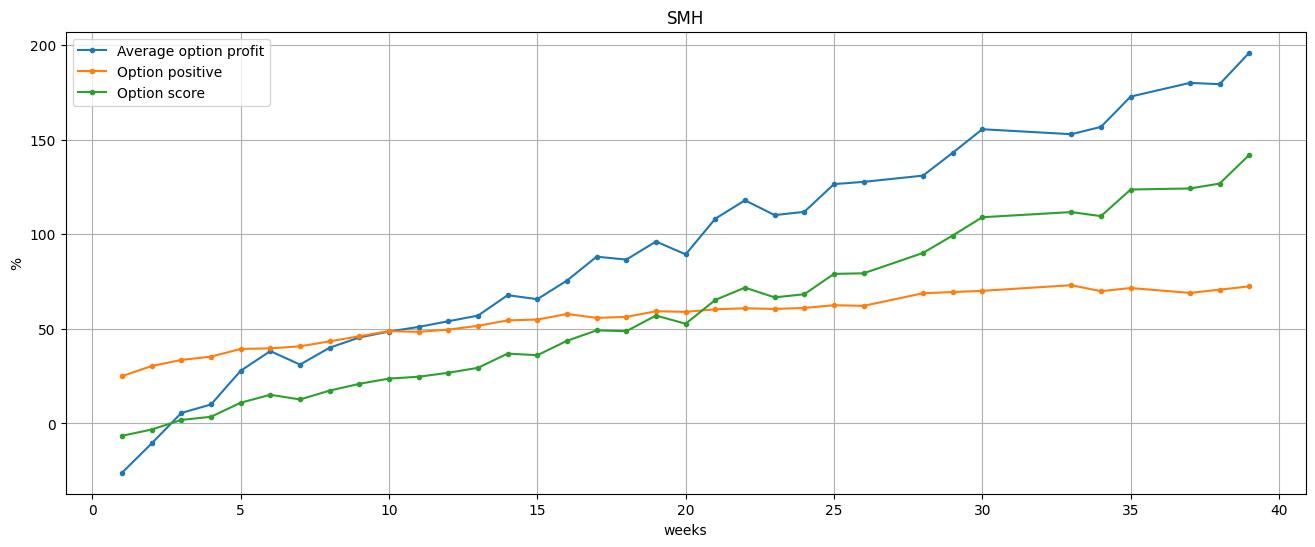

In [8]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

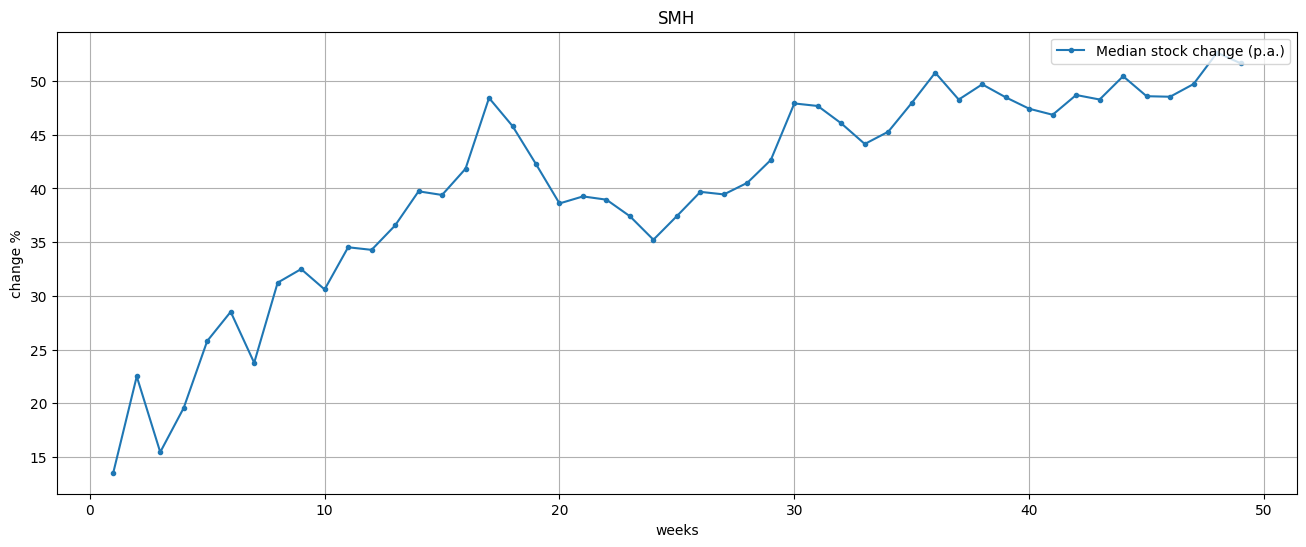

In [9]:
opt = [c * option_leverage[w] - 100 * 52 / w if w in option_leverage else None for w, c in enumerate(stock_change)]

plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change (p.a.)', marker='.')
# plt.plot(opt, label='Median option gain (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


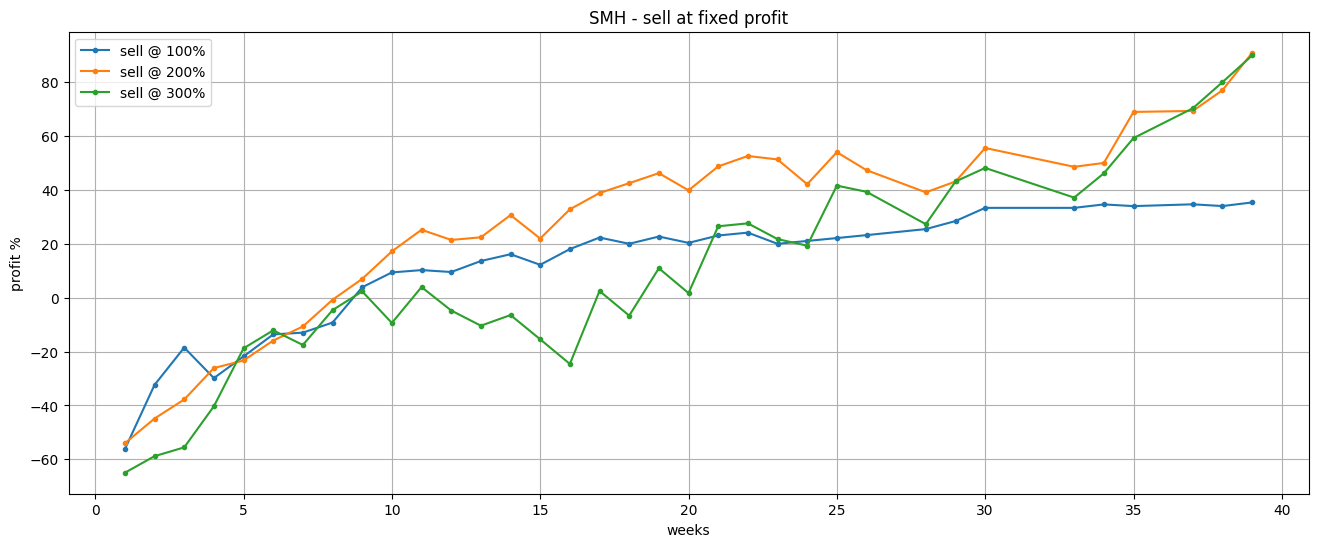

In [10]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()